In [1]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Set memory growth to True to allocate memory as needed
            tf.config.experimental.set_memory_growth(gpu, True)
            # Set a memory limit of 10GB (10240MB)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    except RuntimeError as e:
        print(e)


In [2]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if TensorFlow is using the GPU
if gpus:
    print("Number of GPUs available: ", len(gpus))
    for gpu in gpus:
        print("GPU:", gpu)

    # Perform a simple computation on the GPU
    with tf.device('/GPU:0'):
        a = tf.constant(2.0)
        b = tf.constant(3.0)
        c = a * b
        print(f"Result of computation on GPU: {c.numpy()}")
else:
    print("No GPU found")


TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs available:  1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result of computation on GPU: 6.0


# Get the required data

In [4]:
train_dir = "D:\\Wikiart_splitted\\train"
test_dir = "D:\\Wikiart_splitted\\test"
val_dir= "D:\\Wikiart_splitted\\val"

In [5]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Import necessary libraries and modules

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Splitting the data

In [5]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

# Paths
data_dir = "D:\\Entire Wiki art compressed data"
output_dir = "D:\\Wikiart_splitted"

# Get list of all files with various extensions
extensions = ['jpg', 'jpeg', 'png', 'bmp', 'gif']
all_files = []
for ext in extensions:
    all_files.extend(glob.glob(data_dir + f'/*/*.{ext}'))

# Split data: 80% training, 10% validation, 10% testing
train_files, temp_files = train_test_split(all_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to copy files to the respective directory
def copy_files(file_list, target_dir):
    for file_path in file_list:
        class_name = os.path.basename(os.path.dirname(file_path))
        class_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(file_path, class_dir)

# Copy files to train, val, test directories
copy_files(train_files, os.path.join(output_dir, 'train'))
copy_files(val_files, os.path.join(output_dir, 'val'))
copy_files(test_files, os.path.join(output_dir, 'test'))


# Data Preparation with Image Data Generator

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

batch_size = 32
img_height = 224
img_width = 224

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed  # Seed for reproducibility
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Ensure consistent order
    seed=random_seed  # Seed for reproducibility
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Ensure consistent order
    seed=random_seed  # Seed for reproducibility
)



Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model 1: ResNet50

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Model Training

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    #validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.2547 - accuracy: 0.2676
Epoch 1: val_accuracy improved from -inf to 0.22973, saving model to best_model.h5
1899/1899 [==============================] - 1012s 531ms/step - loss: 2.2547 - accuracy: 0.2676 - val_loss: 2.3207 - val_accuracy: 0.2297
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 2.1192 - accuracy: 0.3038
Epoch 2: val_accuracy did not improve from 0.22973
1899/1899 [==============================] - 992s 522ms/step - loss: 2.1192 - accuracy: 0.3038 - val_loss: 2.6195 - val_accuracy: 0.1862
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 2.0658 - accuracy: 0.3200
Epoch 3: val_accuracy improved from 0.22973 to 0.27778, saving model to best_model.h5
1899/1899 [==============================] - 1021s 537ms/step - loss: 2.0658 - accuracy: 0.3200 - val_loss: 2.1733 - val_accuracy: 0.2778
Epoch 4/10
1899/1899 [==============================] - ETA: 0s - loss: 2

In [9]:
model.save('bagging_cnn1.h5')

# Evaluating the model

In [10]:
model.load_weights('best_model.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 642s 3s/step - loss: 2.0708 - accuracy: 0.3298
Test accuracy: 0.3297732174396515


# Confusion Matrix and Metrics

238/238 [==============================] - 641s 3s/step
Classification Report
                            precision    recall  f1-score   support

               Art_Novueau       0.34      0.30      0.32       413
                   Baroque       0.34      0.33      0.34       418
      Color_field_painting       0.50      0.74      0.59       182
                    Cubism       0.18      0.33      0.23       261
         Early_renaissance       0.30      0.25      0.27       157
             Expressionism       0.24      0.16      0.19       659
                   Fauvism       0.18      0.09      0.12        89
          High_renaissance       0.08      0.02      0.04       126
             Impressionism       0.58      0.46      0.51      1314
Mannerism_late_renaissance       0.19      0.12      0.14       137
                Minimalism       0.31      0.48      0.38       147
    Native_art_primitivism       0.33      0.10      0.15       278
      Northern_renaissance       0.23

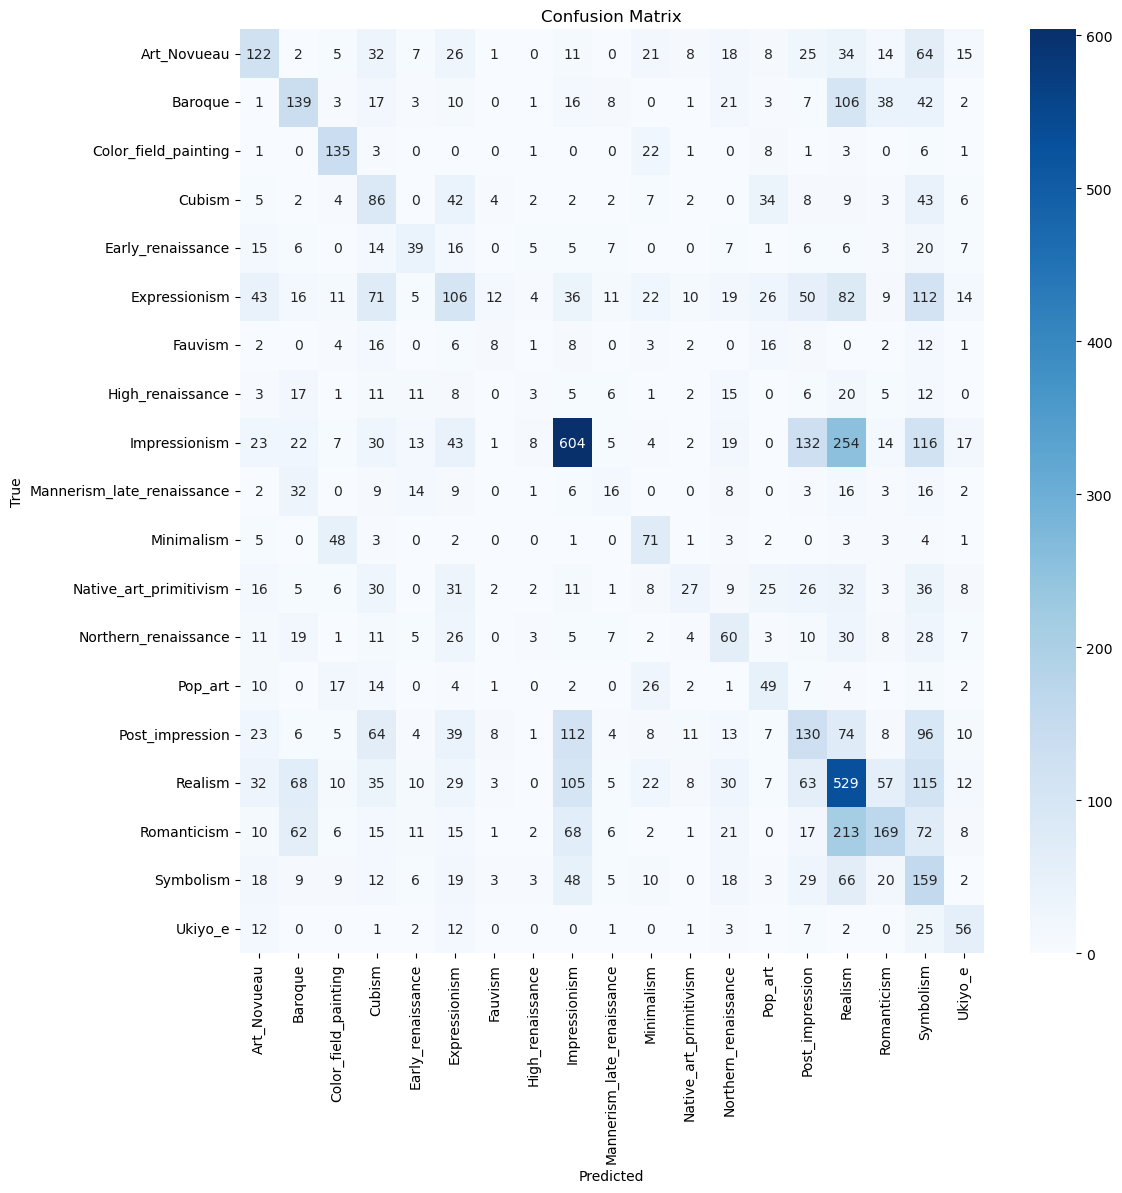

In [11]:
# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Bagging

In [12]:
def bagging_predict(model, generator, steps):
    predictions = []
    for _ in range(5):  # Generate 5 variations for each image
        preds = model.predict(generator, steps=steps)
        predictions.append(preds)
    return np.mean(predictions, axis=0)

bagging_preds = bagging_predict(model, test_generator, test_generator.samples // batch_size)
bagging_accuracy = np.mean(np.argmax(bagging_preds, axis=1) == test_generator.classes[:len(bagging_preds)])
print(f'Bagging test accuracy: {bagging_accuracy}')


237/237 [==============================] - 675s 3s/step
Bagging test accuracy: 0.32977320675105487


# Model 2: Xception

# Data Generation

In [13]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)


batch_size = 32
img_height = 299  # Xception model requires 299x299 images
img_width = 299

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model Building

In [14]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()


83683744/83683744 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                    

# Model training

In [15]:
checkpoint = ModelCheckpoint('best_xcept_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 1.5024 - accuracy: 0.4908
Epoch 1: val_accuracy improved from -inf to 0.58399, saving model to best_xcept_model.h5
1899/1899 [==============================] - 2418s 1s/step - loss: 1.5024 - accuracy: 0.4908 - val_loss: 1.2177 - val_accuracy: 0.5840
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.1129 - accuracy: 0.6143
Epoch 2: val_accuracy improved from 0.58399 to 0.59533, saving model to best_xcept_model.h5
1899/1899 [==============================] - 2287s 1s/step - loss: 1.1129 - accuracy: 0.6143 - val_loss: 1.1973 - val_accuracy: 0.5953
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 0.9296 - accuracy: 0.6739
Epoch 3: val_accuracy improved from 0.59533 to 0.62012, saving model to best_xcept_model.h5
1899/1899 [==============================] - 2284s 1s/step - loss: 0.9296 - accuracy: 0.6739 - val_loss: 1.1153 - val_accuracy: 0.6201
Epoch 4/10
1899/1899 [======

In [16]:
model.save('xcept1.h5')

# Evaluate the model

In [17]:
model.load_weights('best_xcept_model.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 171s 721ms/step - loss: 1.2955 - accuracy: 0.6301
Test accuracy: 0.6301423907279968


 # Confusion Matrix and Metrics Score

238/238 [==============================] - 172s 719ms/step
Classification Report
                            precision    recall  f1-score   support

               Art_Novueau       0.60      0.65      0.62       413
                   Baroque       0.73      0.70      0.71       418
      Color_field_painting       0.88      0.76      0.82       182
                    Cubism       0.70      0.69      0.70       261
         Early_renaissance       0.76      0.72      0.74       157
             Expressionism       0.52      0.54      0.53       659
                   Fauvism       0.62      0.17      0.27        89
          High_renaissance       0.51      0.52      0.51       126
             Impressionism       0.72      0.67      0.70      1314
Mannerism_late_renaissance       0.69      0.45      0.54       137
                Minimalism       0.77      0.79      0.78       147
    Native_art_primitivism       0.70      0.70      0.70       278
      Northern_renaissance       0

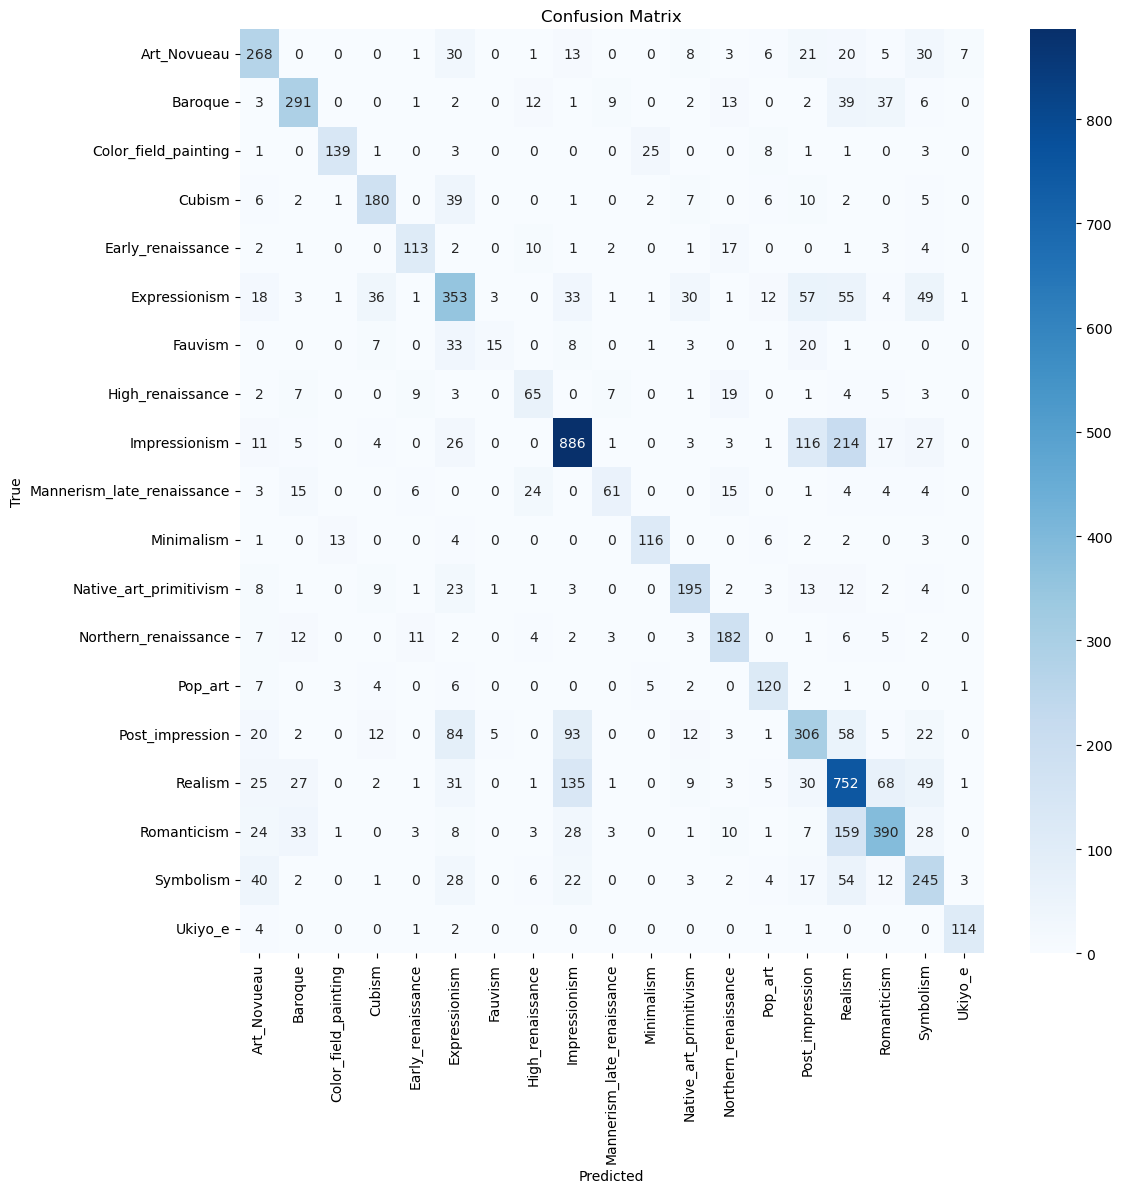

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Model 3: DenseNet121

In [19]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 305, 305, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 150, 150, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [20]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

batch_size = 32
img_height = 224  # Based on DenseNet121
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model training

In [21]:
# Define callbacks
checkpoint = ModelCheckpoint('Densenet121_01.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 1.7321 - accuracy: 0.4257
Epoch 1: val_accuracy improved from -inf to 0.49842, saving model to Densenet121_01.h5
1899/1899 [==============================] - 4502s 2s/step - loss: 1.7321 - accuracy: 0.4257 - val_loss: 1.4754 - val_accuracy: 0.4984
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.4373 - accuracy: 0.5116
Epoch 2: val_accuracy improved from 0.49842 to 0.53428, saving model to Densenet121_01.h5
1899/1899 [==============================] - 4482s 2s/step - loss: 1.4373 - accuracy: 0.5116 - val_loss: 1.3554 - val_accuracy: 0.5343
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 1.3246 - accuracy: 0.5468
Epoch 3: val_accuracy did not improve from 0.53428
1899/1899 [==============================] - 4483s 2s/step - loss: 1.3246 - accuracy: 0.5468 - val_loss: 1.3733 - val_accuracy: 0.5286
Epoch 4/10
1899/1899 [==============================] - ETA: 0s - loss: 1

In [22]:
model.save('Densenet_1.h5')

# Evaluate the model

In [25]:
model.load_weights('Densenet121_01.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 691s 3s/step - loss: 1.2576 - accuracy: 0.5897
Test accuracy: 0.5896624326705933


#  Confusion Matrix and Metrics score

238/238 [==============================] - 691s 3s/step
Classification Report
                            precision    recall  f1-score   support

               Art_Novueau       0.61      0.54      0.57       413
                   Baroque       0.61      0.71      0.65       418
      Color_field_painting       0.81      0.82      0.81       182
                    Cubism       0.65      0.74      0.69       261
         Early_renaissance       0.73      0.59      0.65       157
             Expressionism       0.47      0.55      0.50       659
                   Fauvism       0.40      0.29      0.34        89
          High_renaissance       0.54      0.23      0.32       126
             Impressionism       0.72      0.64      0.68      1314
Mannerism_late_renaissance       0.61      0.34      0.43       137
                Minimalism       0.73      0.73      0.73       147
    Native_art_primitivism       0.67      0.59      0.63       278
      Northern_renaissance       0.47

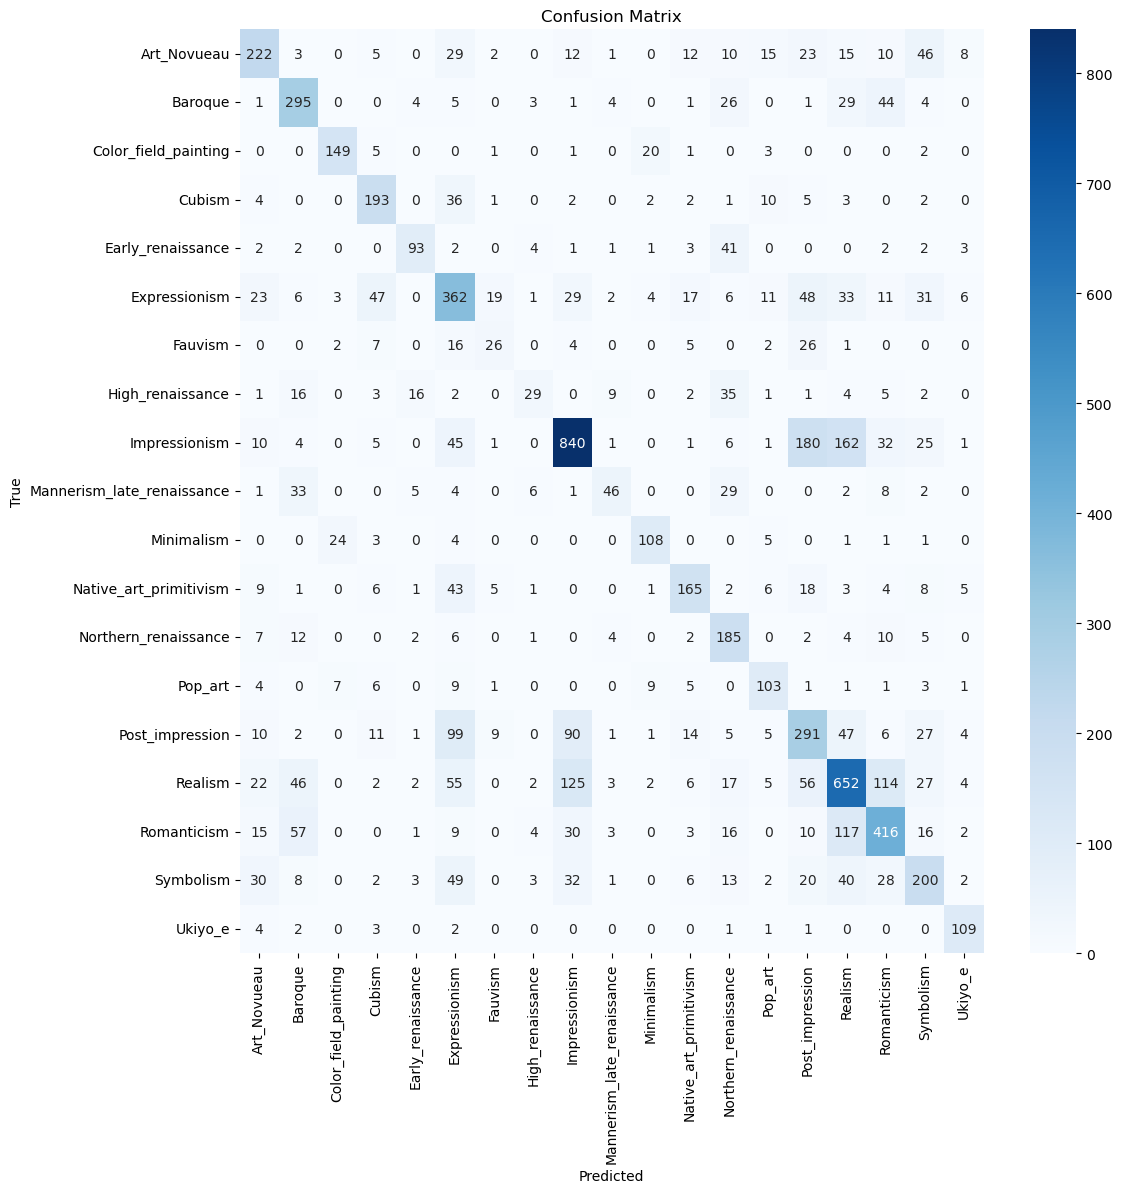

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Model 4: VGG19

# Preparing the data:

In [28]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

batch_size = 32
img_height = 224  # Adjusted for VGG19
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model Building

In [29]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Model Training

In [32]:
# Define callbacks
checkpoint = ModelCheckpoint('vgg19_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.0717 - accuracy: 0.3093
Epoch 1: val_accuracy improved from -inf to 0.31883, saving model to vgg19_1.h5
1899/1899 [==============================] - 2399s 1s/step - loss: 2.0717 - accuracy: 0.3093 - val_loss: 2.0077 - val_accuracy: 0.3188
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.8208 - accuracy: 0.3810
Epoch 2: val_accuracy improved from 0.31883 to 0.36617, saving model to vgg19_1.h5
1899/1899 [==============================] - 2420s 1s/step - loss: 1.8208 - accuracy: 0.3810 - val_loss: 1.8687 - val_accuracy: 0.3662
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 1.6972 - accuracy: 0.4213
Epoch 3: val_accuracy improved from 0.36617 to 0.40968, saving model to vgg19_1.h5
1899/1899 [==============================] - 2418s 1s/step - loss: 1.6972 - accuracy: 0.4213 - val_loss: 1.7374 - val_accuracy: 0.4097
Epoch 4/10
1899/1899 [==============================] -

In [33]:
model.save('VGG19_01.h5')

# Evaluate the model

In [34]:
model.load_weights('vgg19_1.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 103s 429ms/step - loss: 1.4703 - accuracy: 0.4967
Test accuracy: 0.4967035949230194


# Confusion Matrix and Metrics score

238/238 [==============================] - 96s 404ms/step
Classification Report
                            precision    recall  f1-score   support

               Art_Novueau       0.46      0.48      0.47       413
                   Baroque       0.55      0.60      0.57       418
      Color_field_painting       0.78      0.72      0.75       182
                    Cubism       0.64      0.65      0.64       261
         Early_renaissance       0.62      0.34      0.44       157
             Expressionism       0.38      0.44      0.41       659
                   Fauvism       0.49      0.25      0.33        89
          High_renaissance       0.62      0.16      0.25       126
             Impressionism       0.71      0.48      0.57      1314
Mannerism_late_renaissance       0.49      0.28      0.36       137
                Minimalism       0.54      0.71      0.61       147
    Native_art_primitivism       0.39      0.45      0.41       278
      Northern_renaissance       0.

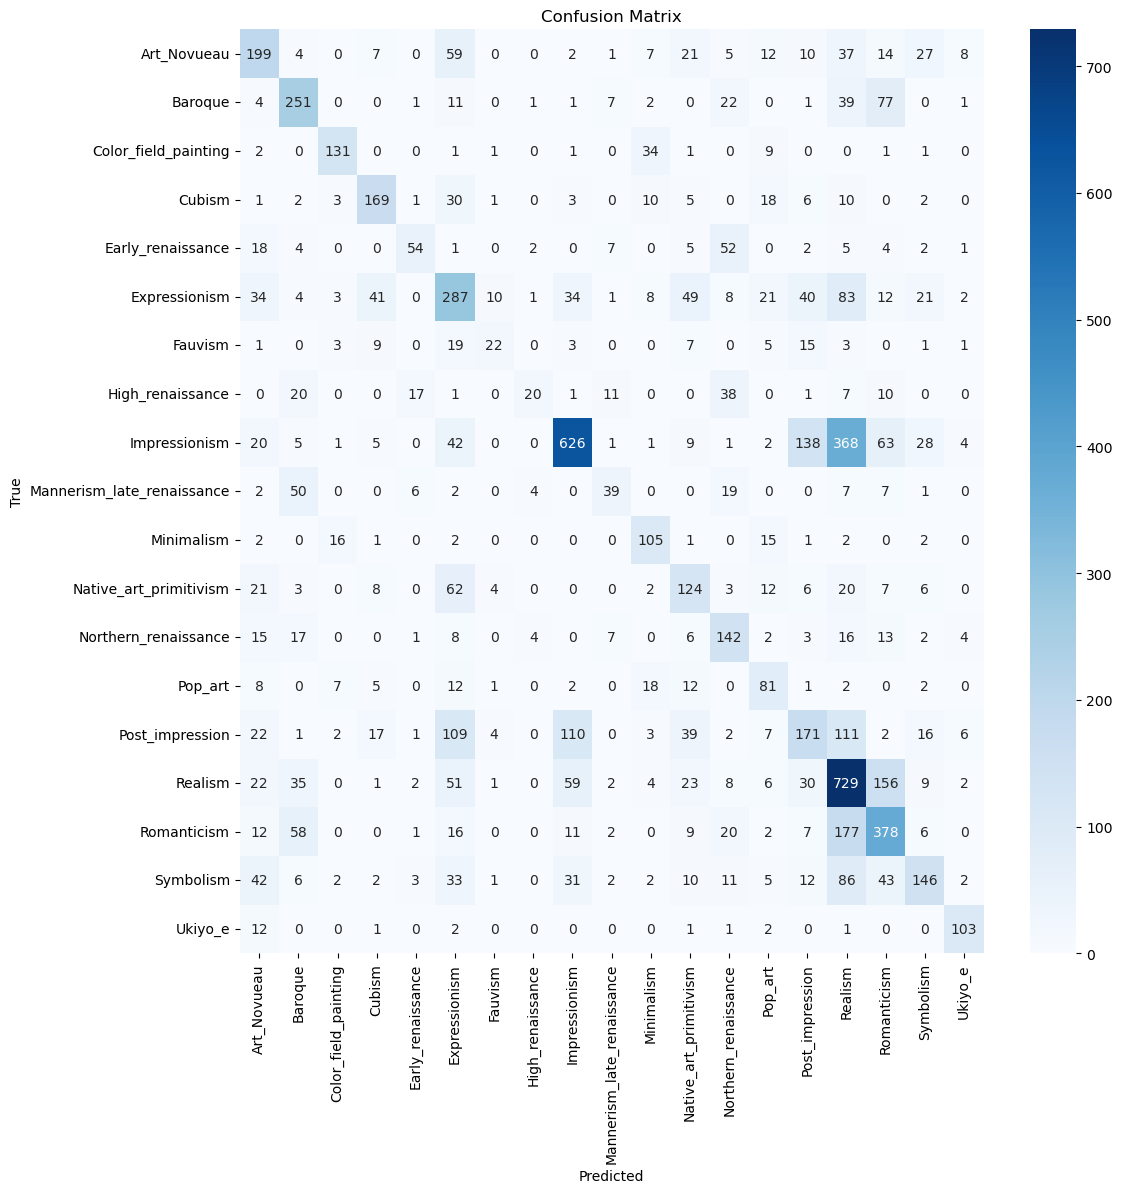

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Model 5 MobileNetV2

# Preparing the data

In [7]:
train_dir = "D:\\Wikiart_splitted\\train"
test_dir = "D:\\Wikiart_splitted\\test"
val_dir= "D:\\Wikiart_splitted\\val"

In [8]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

batch_size = 32
img_height = 224  # Adjusted for VGG19
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model building

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Model training

In [10]:
# Define callbacks
checkpoint = ModelCheckpoint('mobnet_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 1.6606 - accuracy: 0.4434
Epoch 1: val_accuracy improved from -inf to 0.49407, saving model to mobnet_1.h5
1899/1899 [==============================] - 1033s 542ms/step - loss: 1.6606 - accuracy: 0.4434 - val_loss: 1.7059 - val_accuracy: 0.4941
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.3526 - accuracy: 0.5377
Epoch 2: val_accuracy improved from 0.49407 to 0.51965, saving model to mobnet_1.h5
1899/1899 [==============================] - 1017s 535ms/step - loss: 1.3526 - accuracy: 0.5377 - val_loss: 1.4826 - val_accuracy: 0.5196
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 1.2152 - accuracy: 0.5824
Epoch 3: val_accuracy improved from 0.51965 to 0.54523, saving model to mobnet_1.h5
1899/1899 [==============================] - 989s 521ms/step - loss: 1.2152 - accuracy: 0.5824 - val_loss: 1.3640 - val_accuracy: 0.5452
Epoch 4/10
1899/1899 [======================

In [11]:
model.save('mobnet1.h5')

# Evaluate the model

In [12]:
model.load_weights('mobnet_1.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 76s 318ms/step - loss: 1.3837 - accuracy: 0.5695
Test accuracy: 0.5694884061813354


# Confusion Matrix and Metrics score

238/238 [==============================] - 73s 302ms/step
Classification Report
                            precision    recall  f1-score   support

               Art_Novueau       0.51      0.59      0.55       413
                   Baroque       0.71      0.56      0.62       418
      Color_field_painting       0.93      0.57      0.70       182
                    Cubism       0.71      0.61      0.66       261
         Early_renaissance       0.55      0.75      0.64       157
             Expressionism       0.48      0.49      0.48       659
                   Fauvism       0.48      0.24      0.32        89
          High_renaissance       0.47      0.35      0.40       126
             Impressionism       0.68      0.68      0.68      1314
Mannerism_late_renaissance       0.55      0.45      0.49       137
                Minimalism       0.62      0.80      0.70       147
    Native_art_primitivism       0.54      0.57      0.55       278
      Northern_renaissance       0.

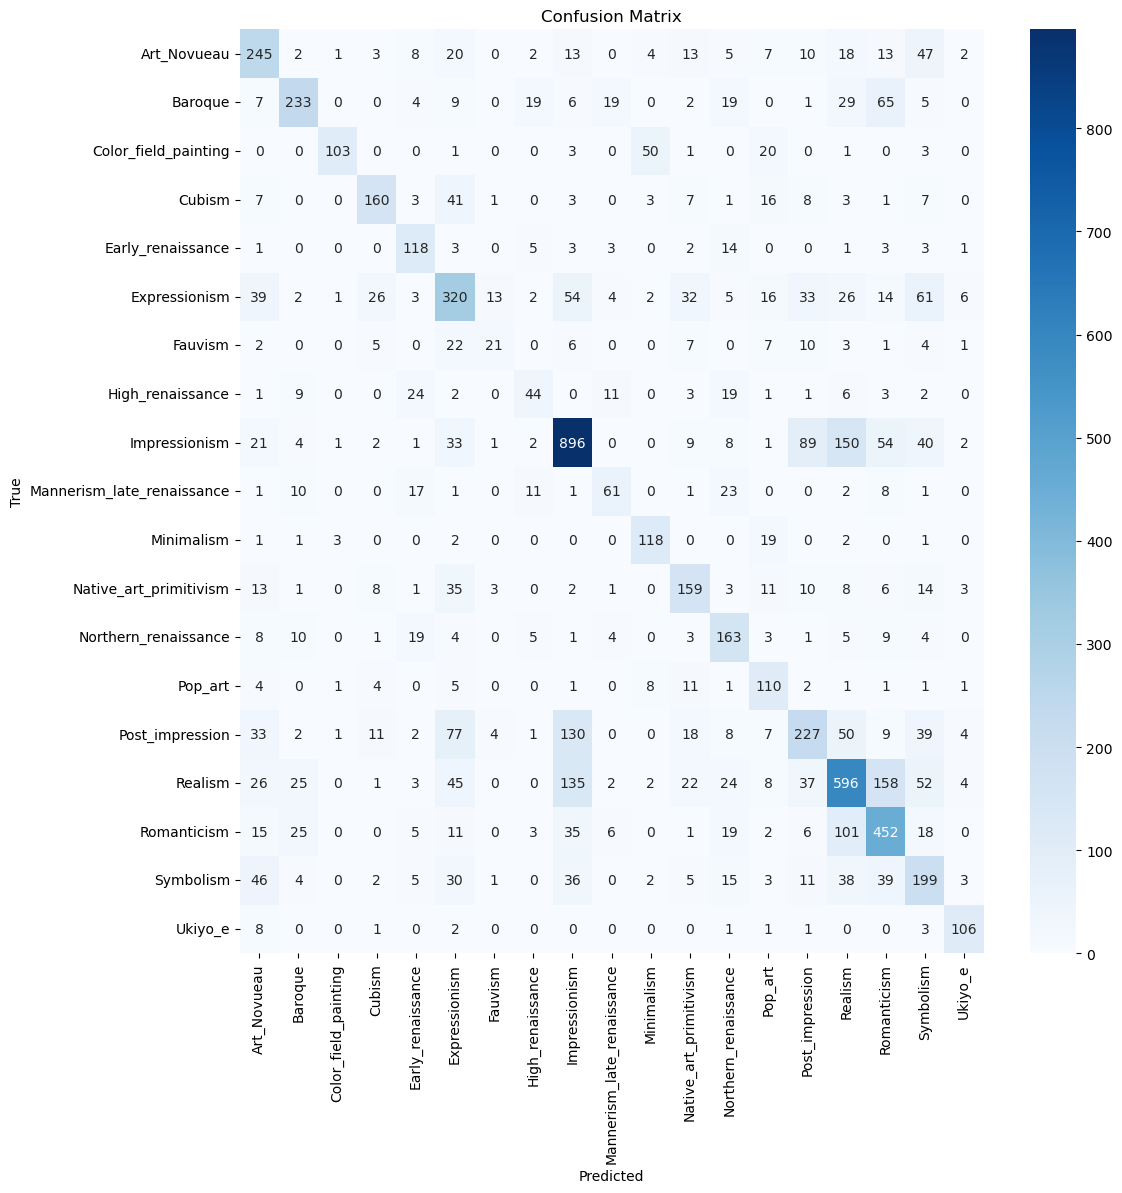

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Model 6: Resnet 152

# Data Preparation

In [6]:
batch_size = 32
img_height = 224  # Adjusted for ResNet152
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model Building

In [7]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the ResNet152 model
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()

234698864/234698864 [==============================] - 8s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

# Model training

In [8]:
# Define callbacks
checkpoint = ModelCheckpoint('resnet150_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.3281 - accuracy: 0.2459
Epoch 1: val_accuracy improved from -inf to 0.14056, saving model to resnet150_1.h5
1899/1899 [==============================] - 1031s 539ms/step - loss: 2.3281 - accuracy: 0.2459 - val_loss: 2.6700 - val_accuracy: 0.1406
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 2.1981 - accuracy: 0.2802
Epoch 2: val_accuracy improved from 0.14056 to 0.29483, saving model to resnet150_1.h5
1899/1899 [==============================] - 1014s 534ms/step - loss: 2.1981 - accuracy: 0.2802 - val_loss: 2.1548 - val_accuracy: 0.2948
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 2.1397 - accuracy: 0.2979
Epoch 3: val_accuracy did not improve from 0.29483
1899/1899 [==============================] - 1032s 543ms/step - loss: 2.1397 - accuracy: 0.2979 - val_loss: 2.6776 - val_accuracy: 0.1818
Epoch 4/10
1899/1899 [==============================] - ETA: 0s - loss

In [11]:
model.save('resnet150_01')

INFO:tensorflow:Assets written to: resnet150_01\assets


INFO:tensorflow:Assets written to: resnet150_01\assets


# Model Evaluation

In [9]:
model.load_weights('resnet150_1.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 79s 330ms/step - loss: 2.1166 - accuracy: 0.2996
Test accuracy: 0.29957807064056396


# Confusion Matrix and Metrics

238/238 [==============================] - 80s 325ms/step
Classification Report
                            precision    recall  f1-score   support

               Art_Novueau       0.22      0.34      0.27       413
                   Baroque       0.32      0.33      0.32       418
      Color_field_painting       0.60      0.47      0.52       182
                    Cubism       0.40      0.08      0.14       261
         Early_renaissance       0.50      0.06      0.10       157
             Expressionism       0.20      0.37      0.26       659
                   Fauvism       0.12      0.01      0.02        89
          High_renaissance       0.00      0.00      0.00       126
             Impressionism       0.45      0.46      0.45      1314
Mannerism_late_renaissance       0.38      0.02      0.04       137
                Minimalism       0.57      0.14      0.22       147
    Native_art_primitivism       0.31      0.05      0.09       278
      Northern_renaissance       0.

C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


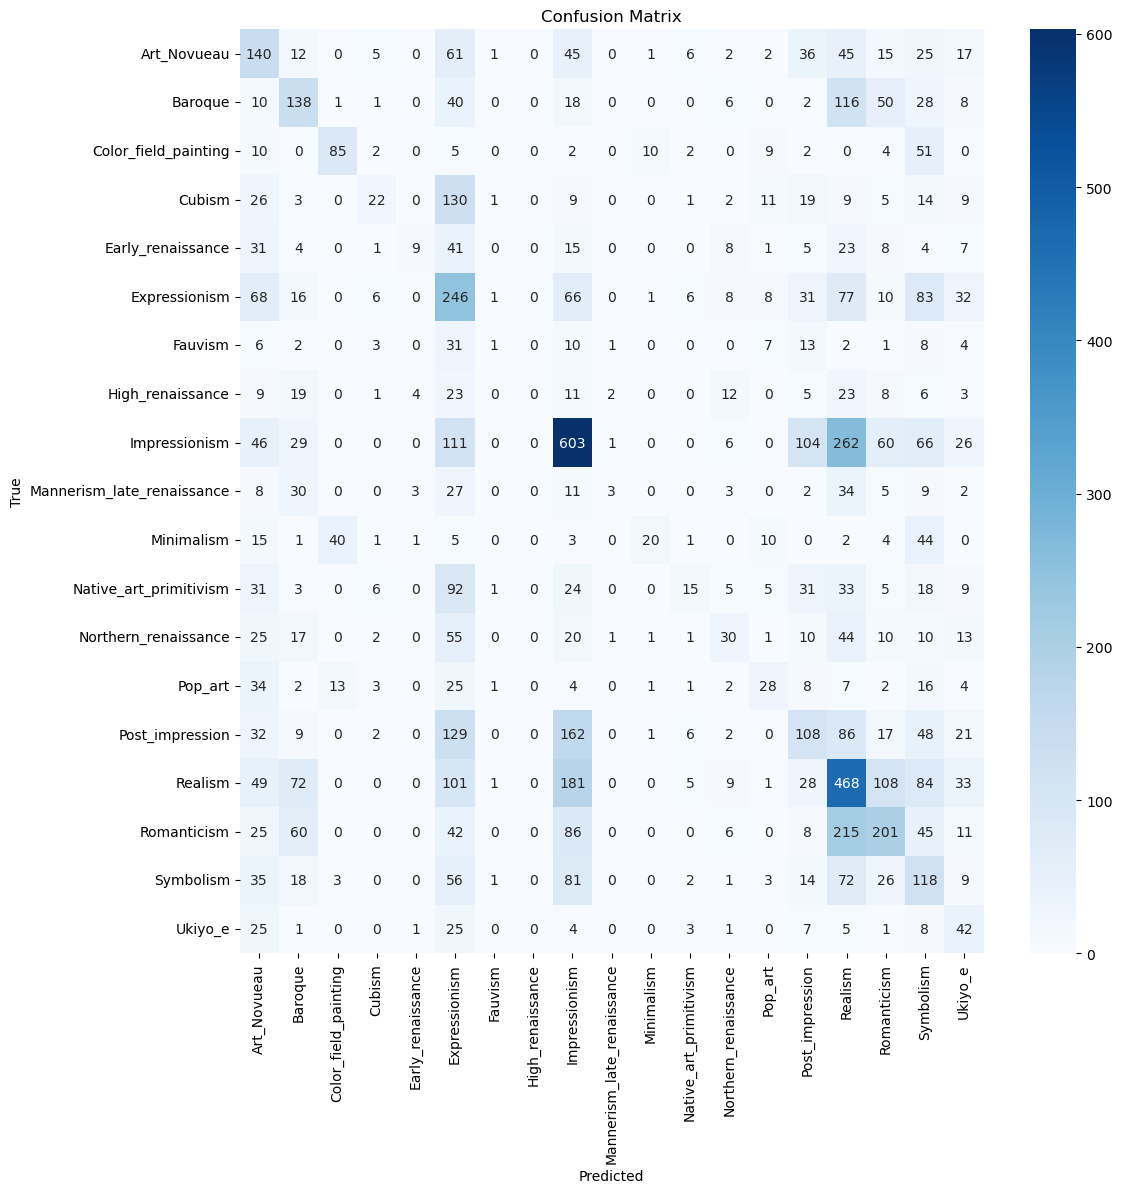

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Model 7: InceptionV3

# Data Preparation

In [17]:
batch_size = 32
img_height = 224  # Adjusted for ResNet152
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model Building

In [19]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

# Model training

In [20]:
# Define callbacks
checkpoint = ModelCheckpoint('inception_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 1.7403 - accuracy: 0.4212
Epoch 1: val_accuracy improved from -inf to 0.46770, saving model to inception_1.h5
1899/1899 [==============================] - 1031s 540ms/step - loss: 1.7403 - accuracy: 0.4212 - val_loss: 1.5403 - val_accuracy: 0.4677
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.4677 - accuracy: 0.5019
Epoch 2: val_accuracy improved from 0.46770 to 0.50659, saving model to inception_1.h5
1899/1899 [==============================] - 1031s 543ms/step - loss: 1.4677 - accuracy: 0.5019 - val_loss: 1.4328 - val_accuracy: 0.5066
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 1.3674 - accuracy: 0.5332
Epoch 3: val_accuracy improved from 0.50659 to 0.51543, saving model to inception_1.h5
1899/1899 [==============================] - 1025s 540ms/step - loss: 1.3674 - accuracy: 0.5332 - val_loss: 1.4302 - val_accuracy: 0.5154
Epoch 4/10
1899/1899 [============

In [21]:
model.save('Inception.h5')

# Evaluating the Model

In [22]:
model.load_weights('inception_1.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 78s 327ms/step - loss: 1.4277 - accuracy: 0.5353
Test accuracy: 0.5353375673294067


# Confusion Matrix and Metrics

238/238 [==============================] - 74s 309ms/step
Classification Report
                            precision    recall  f1-score   support

               Art_Novueau       0.57      0.47      0.51       413
                   Baroque       0.41      0.74      0.52       418
      Color_field_painting       0.78      0.78      0.78       182
                    Cubism       0.52      0.71      0.60       261
         Early_renaissance       0.70      0.47      0.56       157
             Expressionism       0.45      0.39      0.42       659
                   Fauvism       0.53      0.26      0.35        89
          High_renaissance       0.41      0.37      0.39       126
             Impressionism       0.63      0.66      0.64      1314
Mannerism_late_renaissance       0.38      0.35      0.36       137
                Minimalism       0.71      0.70      0.70       147
    Native_art_primitivism       0.53      0.48      0.50       278
      Northern_renaissance       0.

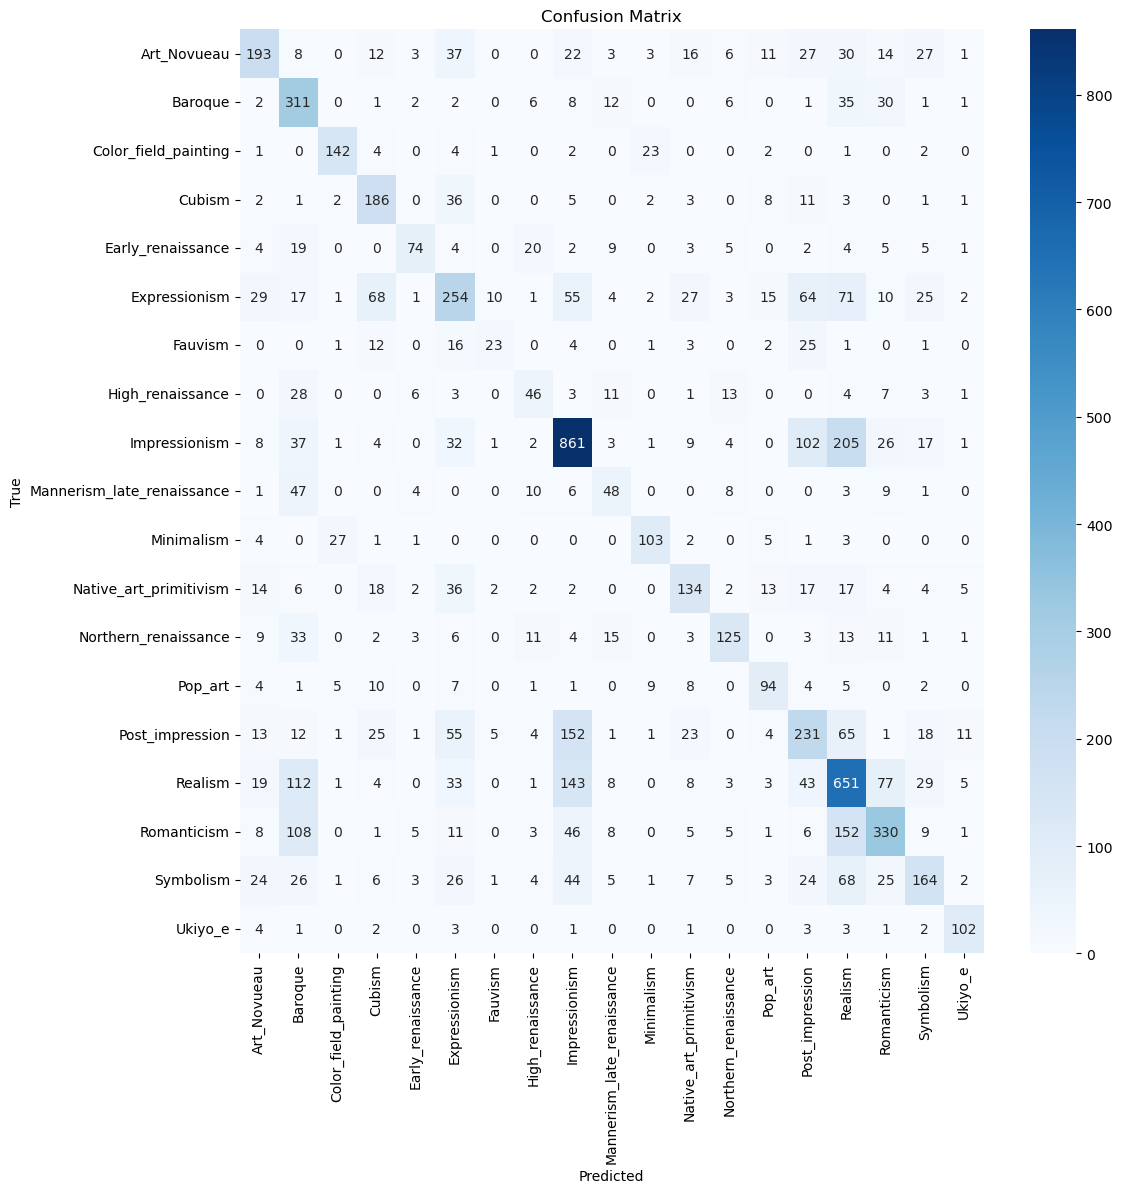

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
